# Example: Inspecting a gas network model from the extended 3DCityDB
This example shows how to read a gas network model from the extended 3DCityDB, using the `dblayer` package. Furthermore, it shows how to use the retrieved *topographical* and *topological* data to visualize the gas network model.

Basic knowledge about [CityGML](http://www.citygmlwiki.org) and the [Utility Network ADE](https://en.wiki.utilitynetworks.sig3d.org) are required for this notebook. A nice overview of the of the basic concepts of the Utility Network ADE can be found [here](https://en.wiki.utilitynetworks.sig3d.org/images/upload/20160913_-_Kolbe_-_Modeling_3D_Utility_Networks_%2B_UtilityNetwork_ADE_Core_Model.pdf).

**Note**: In order to have the 3DCityDB populated with the data required for this example, run notebook *PowerGridModelWriteDB* exactly once.

In [1]:
from dblayer import *
from dblayer.func.func_postgis_geom import *

## Connecting to the database
Define connection parameters for 3DCityDB instance.

In [2]:
connect = PostgreSQLConnectionInfo(
    user = 'postgres',
    pwd = 'postgres',
    host = 'localhost',
    port = '5432',
    dbname = 'testdb'
    )

Connect to database using an instance of class `DBAccess`.

In [3]:
db_access = DBAccess()
db_access.connect_to_citydb(connect)

## Reading data from the database
Package `dblayer` uses an object-oriented apporach for representing and retrieving information from the 3DCityDB. This means that every object defined in the database schema (e.g., `Building`, `EnergyResource`, `Cable`) is mapped to a class, whose variables correspond to the object attributes.

Therefore, before actually reading the data, the classes have to be mapped. This can be done automatically, in which case the mapping between objects and classes uses the standard `citydb` scheme. However, retrieving the mappting from this representation has some drawbacks:
 * For most objects, the data is "fragmented" over several tables. For instance, object `HeatPump` is a specialization of object `EnergyConversionSystem`. Therefore table `nrg8_heat_pump` holds only the attributes specific to `HeatPump`, all attributes it shares with `EnergyConversionSystem` are stored in table `nrg8_conv_system`.
 * Some tables are used for more than one type of object. For instance, objects `Cable` and `Canal` are written to the same table `utn9_distrib_element`.

Fortunately, the extended 3DCityDB provides a remedy for this situation: The `citydb_view` schema defines so-called [views](https://en.wikipedia.org/wiki/View_(SQL)) that present the information in a more complete manner. However, the database contains no information about which types are represented in which views, which is why the user has to provide this information.

In the following, different examples of extracting data are shown, corresponding to different ways this data is represented in the database.

### Retrieving data from a single table

In case all relevant information about an object is stored in a single table, function `get_citydb_objects` can be used to retrieve this information.

For instance, all data required for the examples below about objects of type `FeatureGraph` are stored in one table, which is by default `utn9_feature_graph`. Class `DBAccess` is aware of this and can directly retrieve the stored data.

In [4]:
feature_graphs = db_access.get_citydb_objects( 'FeatureGraph' )

### Retrieving data from a single view

As mentioned above, data is typically fragmented over several tables. In many cases, views providing an aggregated results set of this data can be used. However, the used needs to provide the information from which view the corresponding data should be extracted.

In [5]:
pipes = db_access.get_citydb_objects( 'RoundPipe' ,
    table_name='utn9_ntw_feat_distrib_elem_pipe_round', schema='citydb_view' 
    )

network_nodes = db_access.get_citydb_objects( 'OtherShapePipe' ,
    table_name='utn9_ntw_feat_distrib_elem_pipe_other_shape', schema='citydb_view' 
    )

stations = db_access.get_citydb_objects( 'ComplexFunctionalElement',
    table_name='utn9_ntw_feat_complex_funct_elem', schema='citydb_view'
    )

nodes = db_access.get_citydb_objects( 'Node',
    table_name='utn9_node', schema='citydb_view' 
    )

interior_feature_links = db_access.get_citydb_objects( 'InteriorFeatureLink',
    table_name='utn9_link_interior_feature', schema='citydb_view' 
    )

inter_feature_links = db_access.get_citydb_objects( 'InterFeatureLink',
    table_name='utn9_link_interfeature', schema='citydb_view'
    )

### Retrieving data using filters

If only a subset of the information available in a table or view should be extracted, a set of filter criteria can be specified. To define these filter criteria, the definition of the class mapped to the corresponding object has to be retrieved first.

In [6]:
TerminalElement = db_access.map_citydb_object_class( 'TerminalElement',
    table_name='utn9_ntw_feat_term_elem', schema='citydb_view'
    )

Once the mapped classes are available, the filter criteria can be specified as a list of binary relations and the data can be retrieved using function `get_citydb_objects` of class `DBAccess`.

For instance, both *sinks* and *feeders* are stored as `TerminalElement`, but with different `class` attributes. Therefore, when retrieving the sinks, the additional condition of being a *gas-sink* has to be defined.

In [7]:
sinks = db_access.get_citydb_objects( 'TerminalElement',
    conditions = [ getattr( TerminalElement, 'class' ) == 'gas-network-sink' ]
    )

feeders = db_access.get_citydb_objects( 'TerminalElement',
    conditions = [ getattr( TerminalElement, 'class' ) == 'gas-network-feeder' ]
    )

## Working with the data
As mentioned above, all data is stored as objects, with their respective data attributes as variables with the corresponding name.

This makes it easy to work with this data. For instance, one can easily compile dictionaries of *network features*, *feature graphs* and *feature graph nodes*:

In [8]:
# Map network features to their respective IDs.
network_features = { feature.id: feature for feature in ( network_nodes + sinks + stations + feeders + pipes ) }

# Map feature graph IDs to their associated network feature IDs.
feature_ids = { feature_graph.id: feature_graph.ntw_feature_id  for feature_graph in feature_graphs }

# Map feature graph node IDs to the name of the feature graph node.
node_names = { node.id : node.name for node in nodes }

### Exploring the topological data
All components of the power grid model are associated to *network features*, which basically hold the topographical information. These network features are assocaited to *feature graphs*, which hold the topological information. Feature graphs are constructed from *feature graph nodes*. These nodes can be either linked with a feature graphs (*interior links*) or to nodes of other feature graphs (*inter feature links*).

The following code shows how to use this topological information. With the help of package `networkx`, a graph of all nodes and links is created. Different links (interior vs. inter feature links) are shown in different colors. Nodes associated to different types of network features are shown in different colors, too.

**Note**: The figure should be plotted in "interactive mode", making it possible to zoom in. This allows to explore the topological graph in more detail (e.g., types of links connecting different types of nodes).

<IPython.core.display.Javascript object>


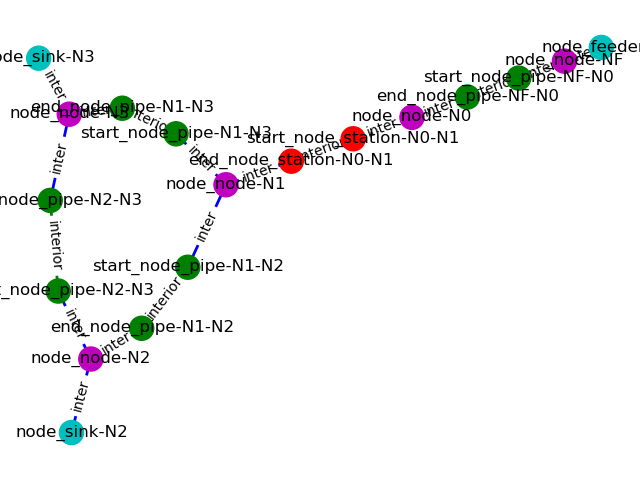

In [9]:
import networkx as nx

def get_node_color( feature_graph_id ):
    feature_color_map = {
        'RoundPipe': 'g',
        'OtherShapePipe': 'm',
        'TerminalElement': 'c',
        'ComplexFunctionalElement': 'r',
        }
    feature_id = feature_ids[ feature_graph_id ]
    feature_type = network_features[ feature_id ].classname
    return feature_color_map[ feature_type ]

def get_link_color( link_type ):
    link_color_map = {
        'interior': 'g',
        'inter': 'b'
        }
    return link_color_map[ link_type ]

# Create new networkx graph.
g = nx.Graph()

# Add all feature graph nodes as nodes of the networks graph. Define different
# color attributes depending on what type of network feature they are associated to.
g.add_nodes_from(
    [ ( node_names[node.id], { 'color': get_node_color( node.feat_graph_id ) } ) for node in nodes ]
)

# Add all inter feature links as edges of the networks graph.
g.add_edges_from( 
    [ ( node_names[link.start_node_id], node_names[link.end_node_id] ) for link in interior_feature_links ],
    link_type = 'interior',
    color = get_link_color( 'interior')
    )

# Add all interior links as edges of the networks graph.
g.add_edges_from(
    [ ( node_names[link.start_node_id], node_names[link.end_node_id] ) for link in inter_feature_links ],
    link_type = 'inter', 
    color = get_link_color( 'inter')
    )

# Import matplotlib package.
%matplotlib notebook
import matplotlib.pyplot as plt

# Extract color attributes from nodes and edges.
edge_colors = [ g[u][v]['color'] for u,v in g.edges() ]
node_colors = [ g.nodes[n]['color'] for n in g.nodes() ]

# Draw the graph.
pos = nx.spring_layout( g, scale = 0.5, iterations = 5000 )
nx.draw( g, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=2 )

# In addition, add the link type (inter/interior) as label for all edges.
edge_labels = nx.get_edge_attributes( g, 'link_type' )
nx.draw_networkx_edge_labels( g, pos, edge_labels )

# Show the figure.
plt.draw()

### Exploring the topographical data
As mentioned above, all components of the gas network model are associated to network features, which basically hold the topographical information. This data is for instance useful to calculate line lengths or visualize the network. The latter is demonstrated in the next example.

Note: The figure should be plotted in "interactive mode", making it possible to zoom in. This allows to explore the topographical view in more detail (especially around the gas network station).

<IPython.core.display.Javascript object>


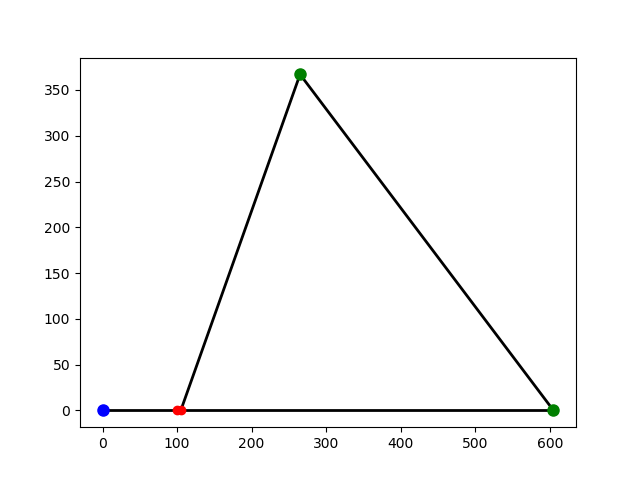

In [10]:
%matplotlib notebook
from matplotlib.path import Path
import matplotlib.patches as patches
from pygeoif import from_wkt

fig, ax = plt.subplots()

#
# The following lines extract the geometric data from the various
# types of network features defined in the power grid model.
#

pipe_plt = []
for pipe in pipes:
    pipe_geom_wkt = db_access.execute_function( geom_as_text( pipe.geom ) )
    pipe_coords = from_wkt( pipe_geom_wkt ).coords
    verts = [ ( c[0], c[1] ) for c in pipe_coords ]
    codes = [ Path.MOVETO, Path.LINETO ]    
    pipe_plt.append( Path( verts, codes ) )

station_plt = []
for station in stations:
    station_geom_wkt = db_access.execute_function( geom_as_text( station.geom ) )
    station_coords = from_wkt( station_geom_wkt ).coords
    verts = [ ( c[0], c[1] ) for c in station_coords ]
    codes = [ Path.MOVETO, Path.LINETO ]    
    station_plt.append( Path( verts, codes ) )

network_node_plt = []
for network_node in network_nodes:
    network_node_geom_wkt = db_access.execute_function( geom_as_text( network_node.geom ) )
    network_node_coords = from_wkt( network_node_geom_wkt ).coords
    network_node_plt.append( [ network_node_coords[0][0], network_node_coords[0][1] ] )

sink_plt = []
for sink in sinks:
    sink_geom_wkt = db_access.execute_function( geom_as_text( sink.geom ) )
    sink_coords = from_wkt( sink_geom_wkt ).coords
    sink_plt.append( [ sink_coords[0][0], sink_coords[0][1] ] )

feeder_plt = []
for feeder in feeders:
    feeder_geom_wkt = db_access.execute_function( geom_as_text( feeder.geom ) )
    feeder_coords = from_wkt( feeder_geom_wkt ).coords
    feeder_plt.append( [ feeder_coords[0][0], feeder_coords[0][1] ] )

#
# The remaining lines call matplotlib and add all elements to the plot.
#

for path in pipe_plt:
    patch = patches.PathPatch( path, edgecolor='black', lw=2 )
    ax.add_patch( patch )

for path in station_plt:
    patch = patches.PathPatch( path, edgecolor='orange', lw=2 )
    ax.add_patch( patch )

plt.plot( *zip(*network_node_plt), marker='o', color='r', ls='')
plt.plot( *zip(*sink_plt), marker='o',  markersize=8, color='g', ls='')
plt.plot( *zip(*feeder_plt), marker='o',  markersize=8, color='b', ls='')

plt.show()

Done.